In [0]:
def resize(path):
    dirs = os.listdir(path)
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((200,200), Image.ANTIALIAS)
            imResize = imResize.convert('RGB')
            imResize.save(f+".jpg", 'JPEG', quality=90)
            if (e !=".jpg"):
              os.remove(path+item)


In [0]:
from PIL import Image
import os, sys

path_normal = '/dbfs/FileStore/tables/X-Ray Image DataSet/normal/'
path_covid = '/dbfs/FileStore/tables/X-Ray Image DataSet/covid/'
path_viral = '/dbfs/FileStore/tables/X-Ray Image DataSet/viral/'

resize(path_normal)
resize(path_covid)
resize(path_viral)

In [0]:
import tensorflow as tf
import pyspark.sql.functions as f
import sparkdl as dl

/databricks/python/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
 from ._conv import register_converters as _register_converters
Using TensorFlow backend.

In [0]:
#dfDjokovic = spark.read.format("image").load('./FileStore/tables/5').withColumn('label', f.lit(0))
#dfFederer = spark.read.format("image").load('./FileStore/tables/X-Ray Image DataSet/covid').withColumn('label', f.lit(1))
from sparkdl.image import imageIO
normal_df= imageIO.readImagesWithCustomFn('./FileStore/tables/X-Ray_Image_DataSet/No_findings', decode_f=imageIO.PIL_decode).withColumn('label', f.lit(0))
covid_df= imageIO.readImagesWithCustomFn('./FileStore/tables/X-Ray_Image_DataSet/Covid-19', decode_f=imageIO.PIL_decode).withColumn('label', f.lit(1))

In [0]:
normal_train, normal_test= normal_df.randomSplit([0.8,0.2])  # use larger training sets (e.g. [0.6, 0.4] for non-community edition clusters)
covid_train, covid_test= covid_df.randomSplit([0.8,0.2])     # use larger training sets (e.g. [0.6, 0.4] for non-community edition clusters)
train_df = normal_train.unionAll(covid_train)
test_df = normal_test.unionAll(covid_test)


In [0]:
display(test_df)

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
#from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer 

featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")
lr = LogisticRegression(maxIter=20, regParam=0.05, elasticNetParam=0.3, labelCol="label")
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
#gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
dt = DecisionTreeClassifier(labelCol="label", maxDepth=15)
p = Pipeline(stages=[featurizer, lr])

p_model = p.fit(train_df)

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

tested_df = p_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(tested_df.select("prediction", "label"))))

Test set accuracy = 0.9565217391304348

In [0]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import expr
def _p1(v):
  return float(v.array[1])
p1 = udf(_p1, DoubleType())

df = tested_df.withColumn("p_1", p1(tested_df.probability))
wrong_df = df.orderBy(expr("abs(p_1 - label)"), ascending=False)
display(wrong_df.select("image.origin", "p_1", "label").limit(10))

origin,p_1,label
dbfs:/FileStore/tables/X-Ray_Image_DataSet/No_findings/00001689_012.jpg,0.3590853080853932,0
dbfs:/FileStore/tables/X-Ray_Image_DataSet/Covid-19/1312A392_67A3_4EBF_9319_810CF6DA5EF6.jpg,0.6848120383851515,1
dbfs:/FileStore/tables/X-Ray_Image_DataSet/Covid-19/0a6c60063b4bae4de001caaba306d1_jumbo.jpg,0.6852329003395327,1
dbfs:/FileStore/tables/X-Ray_Image_DataSet/No_findings/00001452_002.jpg,0.27796059479855845,0
dbfs:/FileStore/tables/X-Ray_Image_DataSet/No_findings/00001650_000.jpg,0.27210202591886606,0
dbfs:/FileStore/tables/X-Ray_Image_DataSet/No_findings/00001389_001.jpg,0.2623098458093526,0
dbfs:/FileStore/tables/X-Ray_Image_DataSet/No_findings/00001638_000.jpg,0.22223038845296275,0
dbfs:/FileStore/tables/X-Ray_Image_DataSet/No_findings/00001516_000.jpg,0.18830719495075968,0
dbfs:/FileStore/tables/X-Ray_Image_DataSet/No_findings/00001362_001.jpg,0.17924176175957585,0
dbfs:/FileStore/tables/X-Ray_Image_DataSet/Covid-19/1_CXRCTThoraximagesofCOVID_19fromSingapore_pdf_001_fig2b.jpg,0.8256305692194691,1


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,normalize=True,title='Confusion matrix',cmap=plt.cm.GnBu):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
from sklearn.metrics import confusion_matrix
y_true = tested_df.select("label")
y_true = y_true.toPandas()
y_pred = tested_df.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred,labels=range(2))

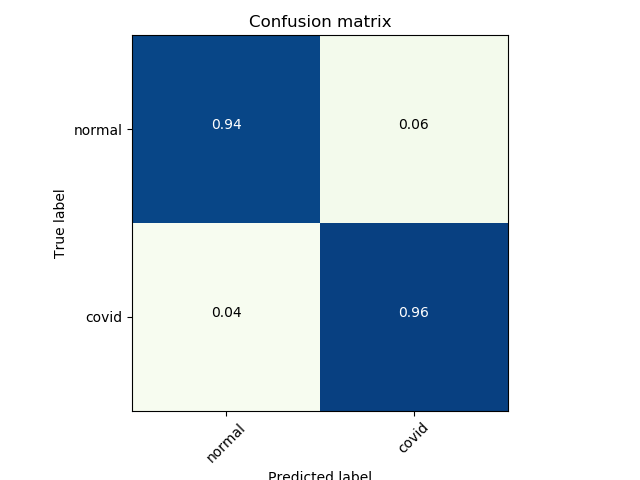

In [0]:
display(plot_confusion_matrix(cnf_matrix, classes=["normal","covid"]))

In [0]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in ["normal","covid"]]
print(classification_report(y_true, y_pred, target_names = target_names))

precision recall f1-score support

Class normal 1.00 1.00 1.00 19
 Class covid 1.00 1.00 1.00 16

 micro avg 1.00 1.00 1.00 35
 macro avg 1.00 1.00 1.00 35
weighted avg 1.00 1.00 1.00 35

In [0]:
print(classification_report(y_true, y_pred))

precision recall f1-score support

 0 0.85 0.74 0.79 23
 1 0.78 0.88 0.82 24

 micro avg 0.81 0.81 0.81 47
 macro avg 0.81 0.81 0.81 47
weighted avg 0.81 0.81 0.81 47